# 1 Problem formulation

The problem is a binary classification, where the purpose of the model is to take an audio file input and give it a female or male label. 

This is an interesting project as it could aid in voice detection technologies found in most household devices such as phones, television sets, or speaker sets. If access to a device is limited to a specific user an early gender check could easily dismiss users who try accessing the device but don't match the authorised user's gender. 

# 2 Machine Learning pipeline

The pipelines inpputs are WAV files, and go through the following stages: 

1. Feature extraction: during this stage pitch mean, and pitch standard deviation are extracted and placed into a dataframe. This is useful as men typically have lower pitch than women, offering the opportunity to distinguish between the two with a high degree of certainty. A label dataframe is created based on the male or female label of each recording on a csv. These labels were achieved through manual labelling. Each participant has a unique code, meaning each code could be labelled with a male or female label. This produced 176 labelled codes. These codes could then be matched with all recordings, resulting in a labelled dataset of 2498 recordings. 

2. A Random Forest Classifier is then trained on these features. This classifier has the following parameters: n_estimators at 1000, min_samples_split at 5, min_samples_lead at 4, max_features at "auto", max_depth at 110, and bootstrap set to True. A Random Forest Classifier is an ensemble model, where the original sample is bootstrapped and a decision tree is generated for it. All the decision trees are then used to determine the class of a label through majority voting. 

3. The model then produces an output which is a label. True means the sample has a female label, and False means the sample has a male label. 

Various versions of this pipeline were experimented with. Initially the training and validation datasets were normalized using a MinMax scaler, however,this resulted in significantly varied results between cross-validation and final validation, where the models would severley overfit. To account for the possibility of outliers significantly decreasing model performance a RoubstScaler was used, however, this did not address the problem. The best results were found when no normalizing was carried out. 

To address the imbalanced nature of the dataset under sampling techniques were utilized where the male samples were undersampled to make them match the female samples, however, this version of the pipeline offered results comparable to classifiers which used the imbalanced data, but used the "balanced accuracy" scoring metric when conducting the grid search function. Therefore, the final pipline utilizes the "balanced accuracy" scoring metric with an imbalanced dataset to not deprive the models of a larger training sample.


# 3 Transformation stage

Feature Extraction: Pitch mean and pitch standard deviation are extracted using the librosa load and pyin functions. The extraction function takes a wav file and outputs two arrays. The first array consists of the pitch features, whilst the second array consists of the labels. Female labels result in a True label, whilst male labels result in a False label. 

Audio files offer a high number of dimensions, however, due to the relatively small sample size limmiting the dataset to two features will lower the chances of overfitting. Furthermore, pitch is highly related to gender, meaning the classifier should be able to extract sufficient patterns to perform well on unseen data. 

The following cell imports all the packages necessary for the project. 

In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns  


from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score


from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import BaggingClassifier
from sklearn import svm 
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier



from google.colab import drive
import os, sys, re, pickle, glob
from tqdm import tqdm
import librosa
import librosa.display

The following cell connects the notebook to the google drive which has the audio files. 

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


The following cell specifies the path towards the audio files, and directs it to a variable which can be used for feature extraction. 

In [ ]:
sample_path = '/content/drive/MyDrive/Data/all_audio/*.wav'
files = glob.glob(sample_path)

The following cell imports a csv which contains the male and female labels for each audio file. 

In [ ]:
MLENDLS_df = pd.read_csv('./ml_gender.csv').set_index('file_id') 
MLENDLS_df.head()

,area,spot,in_out,Participant,Gender
file_id,,,,,
0090.wav,westend,leicester,outdoor,S1,female
0174.wav,kensington,albert,outdoor,S1,female
0213.wav,kensington,cromwell,outdoor,S1,female
0320.wav,campus,ground,indoor,S1,female
0587.wav,westend,national,indoor,S1,female


The following cell contains the extraction functions. The first function uses the librosa.ypin function to extract the pitch. The second function loops through all the files, computing the mean and standard deviation of their pitch and places it into a list, which is then added to an array. It also notes down the label of each file and adds it to the y array. 

In [ ]:
def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag 

def getXy(files,labels_file, scale_audio=False, onlySingleDigit=False):
  X,y =[],[]

  for file in tqdm(files):
    fileID = file.split('/')[-1]
    file_name = file.split('/')[-1]
    yi = labels_file.loc[fileID]['Gender']=='female'

    fs = None # if None, fs would be 22050
    x, sr = librosa.load(file,sr=fs)
    if scale_audio: x = x/np.max(np.abs(x))
    f0, voiced_flag = getPitch(x,sr,winLen=0.02)
      
    power = np.sum(x**2)/len(x)
    pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
    pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
    voiced_fr = np.mean(voiced_flag)

    xi = [pitch_mean,pitch_std]
    X.append(xi)
    y.append(yi)

  return np.array(X), np.array(y)

X,y= getXy(files, labels_file=MLENDLS_df, scale_audio=True, onlySingleDigit=True)

100%|██████████| 2498/2498 [1:11:45<00:00,  1.72s/it]


The output of the cell consists of two arrays. The X array has the pitch features for each file, whilst the y array has the True or False label for each array. 

The following cell puts the X array into a pandas dataframe. 

In [ ]:
X_df = pd.DataFrame(X)
X_df = X_df.rename(columns = {0:"pitch_mean", 1:"pitch_sd"})
X_df.head()

,pitch_mean,pitch_sd
0,124.366324,37.368706
1,133.282051,23.992064
2,0.000000,0.000000
3,236.657708,48.055864
4,195.189920,22.814062


The output is a pandas dataframe with the two pitch features. 

The following cell creates a dataframe with each sample having its male or female label. 

In [ ]:
X_y = pd.DataFrame(X)
X_y = X_y.rename(columns = {0:"pitch_mean", 1:"pitch_sd"})
X_y["labels"] = y
X_y.head()

,pitch_mean,pitch_sd,labels
0,124.366324,37.368706,False
1,133.282051,23.992064,False
2,0.000000,0.000000,False
3,236.657708,48.055864,True
4,195.189920,22.814062,True


The output is a pandas dataframe with the pitch features and the respective label of each sample. This makes it easier to explore and visualize the data later. 

The X and y dataframes are split into training and validating portions, with a 70%/30% split respectively. 

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_df,y,test_size=0.3, random_state = 10)

# 4 Modelling

Six models are built and evaluated through cross-validation. The first four are K-Nearest Neighbors, Gaussian Naive Bayes, a Logistic Regression. 

The following three are ensemble methods. The first is the RandomForestClassifier, the second the AdaBoostClassifier, and the third a 
VotingClassifier using the three classifiers mentioned in the previous paragraph in addition to the AdaBoostClassifier and RandomForestClassifier as its voters. 

The following hyper-parameters are tested for the models:

KNN: k values from 1 to 100. 

Gaussian Naive Bayes: the var_smoothing value ranges from 1e-05 to 1e-13. 

Logistic Regression: the C values of 100, 10, 1.0, 0.1 and 0.01 are tested. Class weights are set to balanced to account for the imbalanced dataset.

Random Forest Classifier: The following n_estimator values are tested: 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000. The max_features "auto" and "sqrt" options are tested. For max_depth the following values are tested: 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110 as well as None. The values 2, 5 and 10 are used for min_samples_split, and the values 1, 2 and 4 for min_sampels_leaf. For bootstrapping True and False are returned. The RandomForest classifier is the only classifier which uses the RandomizedSearchCV function rather than GridSearch due to the relatively high number of hyperparameters and the high computational cost of the model. 

AdaBoostClassifier: The AdaBoostClassifier uses the values: 10, 50, 100 and 500 for the n_estimators hyperparameter, and the values 1.0, 0.1, 0.01, 0.0001, and 0.0001 for the learning_rate hyperparameter. 

VotingClassifier: This classifier uses the the KNN, Gaussian Naive Bayes, Logistic Regression, RandomForestClassifier and the AdaBoostClassifier. Each of these classifiers uses the optimal parameters found previously. 

The first three models were used as they have the capacity for binary classification and are relatively inexpensive in terms of computational requirements.

The ensemble methods were used as more computationally expensive options, in an attempt to produce better accuracy results. 

# 5 Methodology

The initial dataset of 2498 samples will be randomly divided into a 70% training portion and a 30% validation portion. The randomness is designed to not bias the training process towards any specific subsets of the data, meaning the model can perform well on unseen data. 

The 70-30 split is designed to offer the model enough data to find the patterns in the data during training, and to estimate an accurate testing performance during validation. 

During the training process cross-validation using 5 folds will find the optimal hyperparameters for each model. As the data is imbalanced in favour of men the scoring metric will be "balanced_accuracy". 

Balanced accuracy is an average between specificity and sensitivity. Specificity refers to the number of true positives which were predicted out of all positives which exist (which includes true positives and false negatives).Sensitivity refers to the number of true negatives out of all negatives which exist(which includes true negatives and false positives). The two are added and divided by two.

In cases where the data is imbalanced this offers a supperior performance metric to accuracy, as it optimizes the performance of the model through accounting for its ability to classify both classes. 

# 6 Dataset

The data consists of 2498 audio samples, with each sample having a pitch mean and a pitch standard deviation feature. Each sample also has a male or female label, which was achieved through manual labelling. Initially there were 2500 files, however, 2 of them were faulty and produced errors during the feature extraction process, meaning they were removed. 



The below cell visualizes the distribution of male and female labels across the two features. It appears the two are somewhat distinct when looking at pitch mean, and less so when looking at pitch standard deviation. 

Overall, the classifiers should be able to predict the labels with a success rate which is better than random. 

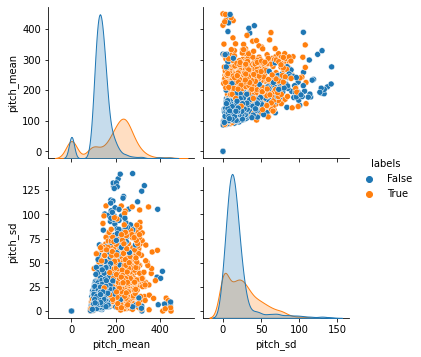

In [ ]:
sns.pairplot(X_y, hue = "labels")

The following cell shows the counts of both labels.

In [ ]:
X_y["labels"].value_counts()

False    1514
True      984
Name: labels, dtype: int64

In [ ]:
(984/(1514+984)) * 100

39.391513210568455

There are far more false (male) labels than true (female) labels, meaning the dataset is quite significantly imbalanced. The minority class accounts for 39% of the dataset. 

# 7 Results


## KNN

The following cell runs the K-Nearest Neighbors function. The knn_val function includes the generation of the various hyperparameter options, and then testing those hyperparameters using the GridSearchCV function. A cv value of 5 is used, meaning 5 folds are being used. The "balanced accuracy" scoring option is used to ensure the GridSearchCV function finds the hyperparameters which classify the two classes evenly. 

In [ ]:
def knn_val():
  # Generating all hyperparameter values 
  k_list = []
  for i in range(1, 100):
    k_list.append(i)
  
  param_grid_knn = {"n_neighbors" : k_list}

  # Computing accuracies for non-transformed data
  knn_initial = KNeighborsClassifier()
  knn = GridSearchCV(knn_initial, param_grid_knn ,cv = 5, scoring = "balanced_accuracy")

  knn.fit(X_train, y_train)

  return knn.best_score_, knn.best_params_


knn_best_score, knn_best_params = knn_val()
knn_best_score, knn_best_params

(0.8534452925511882, {'n_neighbors': 33})

The cell has two outputs. The first is the cross-validation accuracy of the best performing hyperparameters, and the second the best performing hyperparameter. 

## GNB

The following cell trains and cross-validates the Gaussian Naive Bayes classifier. The function generates options for the var_smoothing hyperparameter ranging from 1e-05 to 1e-13. The function then cross-validates across 5 folds, using "balanced accuracy" as the scoring metric. 

In [ ]:
def gnb_val():
  # Defining hyperparameters
  parameters_gnb = [1e-05, 1e-06, 1e-07, 1e-08, 1e-09, 1e-10, 1e-11, 1e-12, 1e-13]
  param_gnb = {"var_smoothing" : parameters_gnb}

  gnb_init = GaussianNB()
  gnb = GridSearchCV(gnb_init, param_gnb, scoring = "balanced_accuracy")
  gnb.fit(X_train, y_train)

  
  return gnb.best_score_, gnb.best_params_

gnb_best_score, gnb_best_params = gnb_val()
gnb_best_score, gnb_best_params

(0.8046228280255399, {'var_smoothing': 1e-05})

The cell has two outputs, the cross-validation accuracy and the best hyperparameters. 

## Logistic Regression

The following cell trains and cross-validates the logistic regression classifier. C values of 100, 10, 1.0, 0.1, and 0.01 are tested. A max_iter of 300 is set, and the class_weight is set to "balanced" to account for the imbalanced dataset. The classifier is cross-validated across 5 folds, using "balanced accuracy" as the scoring metric. 

In [ ]:
def logistic_regression_val():
  c = [100, 10, 1.0, 0.1, 0.01]
  log_reg_param = {"C" : c}

  logreg_init = LogisticRegression(max_iter = 300, class_weight = "balanced")
  logreg = GridSearchCV(logreg_init, log_reg_param, scoring = "balanced_accuracy")
  logreg.fit(X_train, y_train)

  return logreg.best_score_, logreg.best_params_

logreg_best_score, logreg_best_params = logistic_regression_val()
logreg_best_score, logreg_best_params

(0.7438449309756616, {'C': 100})

The cell has two outputs. The first is the cross-validation score, and the second the optimal hyperparameter. 

## Random Forest

The following cell trains and cross-validates the random forest classifier. 6 hyperparameters are tested. The n_iter setting is set to 80, and the classifier is cross-validated across 5 folds using the "balanced_accuracy" scoring metric. 

In [ ]:
def random_forest():
  n_estimators = [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
  max_features = ['auto', 'sqrt']
  max_depth = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]
  max_depth.append(None)
  min_samples_split = [2, 5, 10] 
  min_samples_leaf = [1, 2, 4]
  bootstrap = [True, False]

  random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

  rf = RandomForestClassifier()
  rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 80, cv = 5, scoring = "balanced_accuracy")
  rf_random.fit(X_train, y_train)


  return rf_random.best_score_, rf_random.best_params_

rf_random_best_score, rf_random_best_params = random_forest()
rf_random_best_score, rf_random_best_params

(0.8482364934811711,
 {'n_estimators': 2000,
  'min_samples_split': 5,
  'min_samples_leaf': 4,
  'max_features': 'sqrt',
  'max_depth': None,
  'bootstrap': True})

The cell has two outputs. The cross-validation accuracy, and the best hyperparameters. 

## Ada Boost Classifier

The following cell trains and cross-validates the AdaBoostClassifier. It tunes the n_estimators and learning_rate hyperparameters. It cross_validates across 5 folds, and uses the balanced_accuracy scoring metric. 

In [ ]:
def ada_boost():
  ada_param_grid = {"n_estimators" : [10, 50, 100, 500],
                    "learning_rate" : [0.0001, 0.001, 0.01, 0.1, 1.0]}
  
  ada_init = AdaBoostClassifier()
  ada = GridSearchCV(estimator=ada_init, param_grid=ada_param_grid, cv=5, scoring = "balanced_accuracy")
  ada.fit(X_train, y_train)

  return ada.best_score_, ada.best_params_

ada_best_score, ada_best_params = ada_boost()
ada_best_score, ada_best_params

(0.8411874412463776, {'learning_rate': 1.0, 'n_estimators': 500})

The cell has two outputs. The cross-validation accuracy, and the best hyperparameters. 

## Voting Classifier

The following cell fits the Voting Classifier. The model has 5 voters: KNN, Logistic Regression, GNB, Random Forest, and the AdaBoostClassifier. Each voter uses the optimal parameters achieved through cross_validation. 

In [ ]:
def voting_classifier():
  
  knn = KNeighborsClassifier(n_neighbors = 33)

  logreg = LogisticRegression(C = 100)

  gnb = GaussianNB(var_smoothing = 1e-05)

  rf = RandomForestClassifier(n_estimators = 1000,
                              min_samples_split = 5, 
                              min_samples_leaf = 4, 
                              max_features = "auto", 
                              max_depth = 110, 
                              bootstrap = True)

  ada = AdaBoostClassifier(learning_rate = 1.0, n_estimators = 500)
  
  vc = VotingClassifier(estimators = [("knn", knn), ("logreg", logreg), ("gnb", gnb),("rf", rf), ("ada", ada)], voting = "hard")
  vc.fit(X_train, y_train)


  return cross_val_score(vc, X_train, y_train, cv=5)

vc_score = voting_classifier()
sum(vc_score)/len(vc_score)

0.8506884977486697

The cell has one output. The average cross-validation score of the voting classifier. 

## Re-training best classifiers 

The Voting Classifier, the Random Forest Classifier and the KNN Classifier produced the best cross-validation accuracies, therefore they shall be retrained on the entire 70% of the training data, before a final test on the validation dataset which consists of 30% of the original dataset. 

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 33)

logreg = LogisticRegression(C = 100)

gnb = GaussianNB(var_smoothing = 1e-05)

rf = RandomForestClassifier(n_estimators = 1000,
                            min_samples_split = 5, 
                            min_samples_leaf = 4, 
                            max_features = "auto", 
                            max_depth = 110, 
                            bootstrap = True)

ada = AdaBoostClassifier(learning_rate = 1.0, n_estimators = 500)
  
vc = VotingClassifier(estimators = [("knn", knn), ("logreg", logreg), ("gnb", gnb),("rf", rf), ("ada", ada)], voting = "hard")
vc.fit(X_train, y_train)
print(vc.score(X_train, y_train))
print(vc.score(X_val, y_val))

0.8707093821510298
0.832


In [ ]:
y_pred = vc.predict(X_val)
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

              precision    recall  f1-score   support

       False       0.86      0.86      0.86       458
        True       0.78      0.79      0.78       292

    accuracy                           0.83       750
   macro avg       0.82      0.82      0.82       750
weighted avg       0.83      0.83      0.83       750

[[394  64]
 [ 62 230]]


In [ ]:
knn.fit(X_train, y_train)
print(knn.score(X_train, y_train))
print(knn.score(X_val, y_val))

0.8569794050343249
0.836


In [ ]:
y_pred = knn.predict(X_val)
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

              precision    recall  f1-score   support

       False       0.88      0.85      0.86       458
        True       0.78      0.82      0.79       292

    accuracy                           0.84       750
   macro avg       0.83      0.83      0.83       750
weighted avg       0.84      0.84      0.84       750

[[389  69]
 [ 54 238]]


In [ ]:
rf.fit(X_train, y_train)
print(rf.score(X_train, y_train))
print(rf.score(X_val, y_val))

0.9004576659038902
0.8413333333333334


In [ ]:
y_pred = rf.predict(X_val)
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

              precision    recall  f1-score   support

       False       0.89      0.84      0.87       458
        True       0.77      0.84      0.81       292

    accuracy                           0.84       750
   macro avg       0.83      0.84      0.84       750
weighted avg       0.85      0.84      0.84       750

[[385  73]
 [ 46 246]]


After training on the entire training data and testing on the validation data the Random Forest Classifier returns the best performance, at 0.84 accuracy on unseen data. In addition to this the classification reports and confusion matrices show the Random Forest Classifier gives the most balanced performance across the two classes with the highest f1 scores for both male and female labels. Therefore, the RandomForest classifier is chosen as the optimal model for this problem. 

# 8 Conclusions

To conclude, a the optimal model for this dataset was a Random Forest Classifier, which achieved an accuracy and f1 score of 0.84. 

Possible improvements could include a greater range of features, which could be aquired through the assistance of audio professionals with domain expertise. Furthermore, a larger sample size could facilitate deep learning applications, or push the accuracy higher on the Random Forest Classifier. 

